In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

sys.path.append("../../")
import pytcspc as pc

%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams.update({'font.size': 12, 'font.sans-serif': 'DejaVu Sans'})

D:\Dropbox\code\pyTCSPC\examples\fit_from_image\../..\pyTCSPC\batch.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# load IRF

we will use the M2 channel

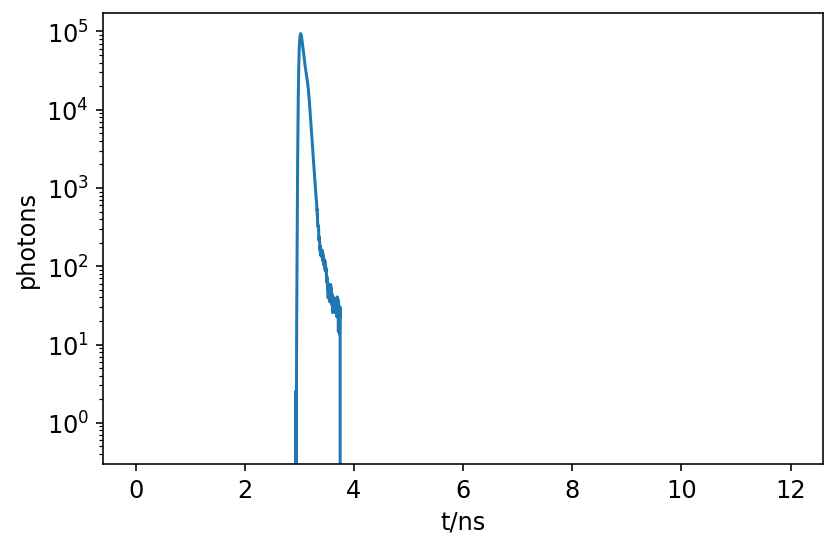

In [2]:
fig, ax = plt.subplots(figsize=(6,4))
irf = pc.load_sdt(r"sample_data/IRF.sdt", dims="CXM", dtype=np.uint32, use_dask=False)

dc_kwargs_M2 = {"trunc": True, "peak_start": 2.93, "peak_end": 3.75, "bgsub": True, "bg_start": 8, "bg_end": 10, "fig": fig, "ax": ax}
fig, ax, irfdc_M2 = pc.decay_curve(irf.sel(channel="M2"), plot=True, **dc_kwargs_M2)
# plt.yscale("linear")

# load data

we will again use the M2 channel, and pool the decay curves from all pixels

In [3]:
flimg  = pc.load_sdt("sample_data/SDT_c01.sdt", use_dask=False).isel(file_info=0).sel(channel="M2")
dc = pc.decay_curve(flimg)

# perform fitting

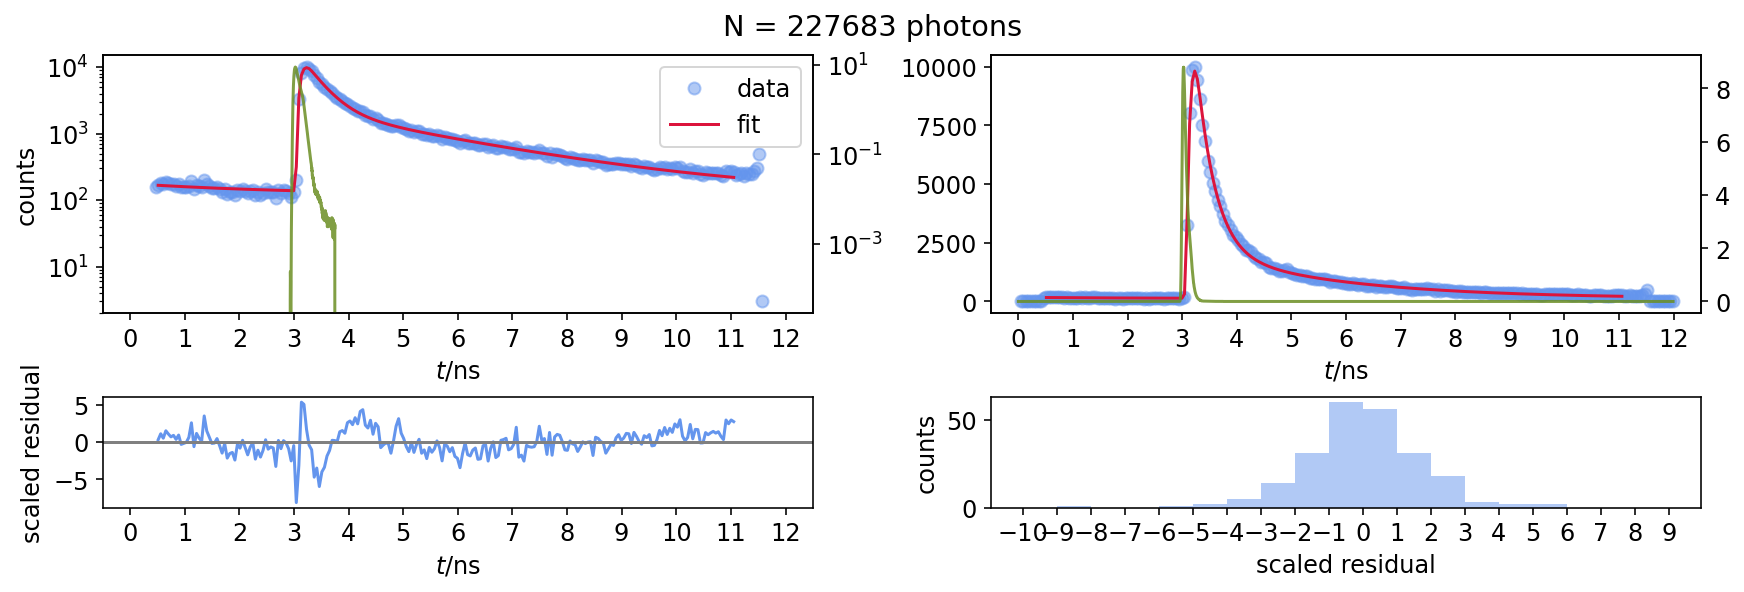

,value,err,min,max,step
shift,16.500000,0.351153,-300.000,300.0,1.000
A,0.991359,0.001028,0.700,1.0,0.001
tau1,2.567082,0.131130,1.000,9.0,0.001
tau2,0.329737,0.006843,0.010,1.0,0.001
f,0.154874,0.005741,0.001,1.0,0.001


In [4]:
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)

parameters = {
    "shift": {"value": 0    , "err": np.nan, "min": -300 , "max":   300, "step": 1   },
    "A":     {"value": 0.995, "err": np.nan, "min": 0.700, "max": 1.000, "step": 1e-3},
    "tau1":  {"value": 1.8,   "err": np.nan, "min": 1.000, "max": 9.000, "step": 1e-3},
    "tau2":  {"value": 0.25,  "err": np.nan, "min": 0.010, "max": 1.000, "step": 1e-3},
    "f":     {"value": 0.25,  "err": np.nan, "min": 0.001, "max": 1.000, "step": 1e-3},
}

fit_result, fit_status = dg.fit(model="2exp", parameters=parameters, plot=True)
display(fit_result)

The fitting looks OK. Because a two-exp model is an approximation for NAD(P)H FLIM data, the residual does have some structure

But maybe we don't want to use all the pixels in the image to get the decay curve in the first place. Let's be more selective.

# what does the image look like?

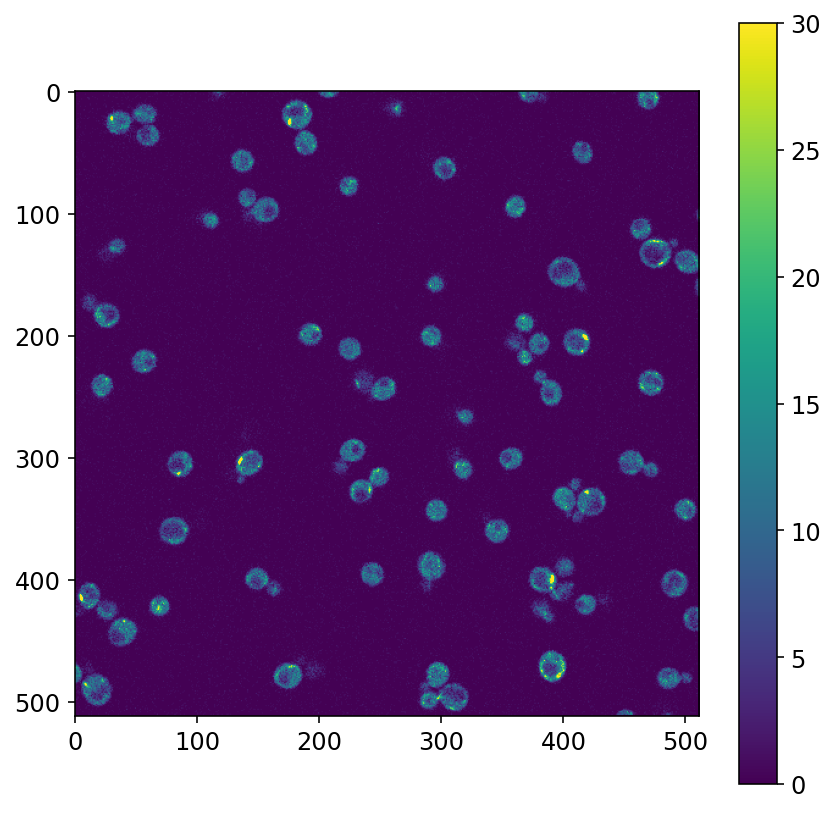

In [5]:
int_img = flimg.sum("microtime_ns").data

fig, ax = plt.subplots(figsize=(7,7))
plt.imshow(int_img, vmin=0, vmax=30)
plt.colorbar()

# segment image

we will do this by applying a Gaussian blur and thresholding -- a fairly crude but easy method

In [6]:
from skimage.filters import gaussian

## blur image

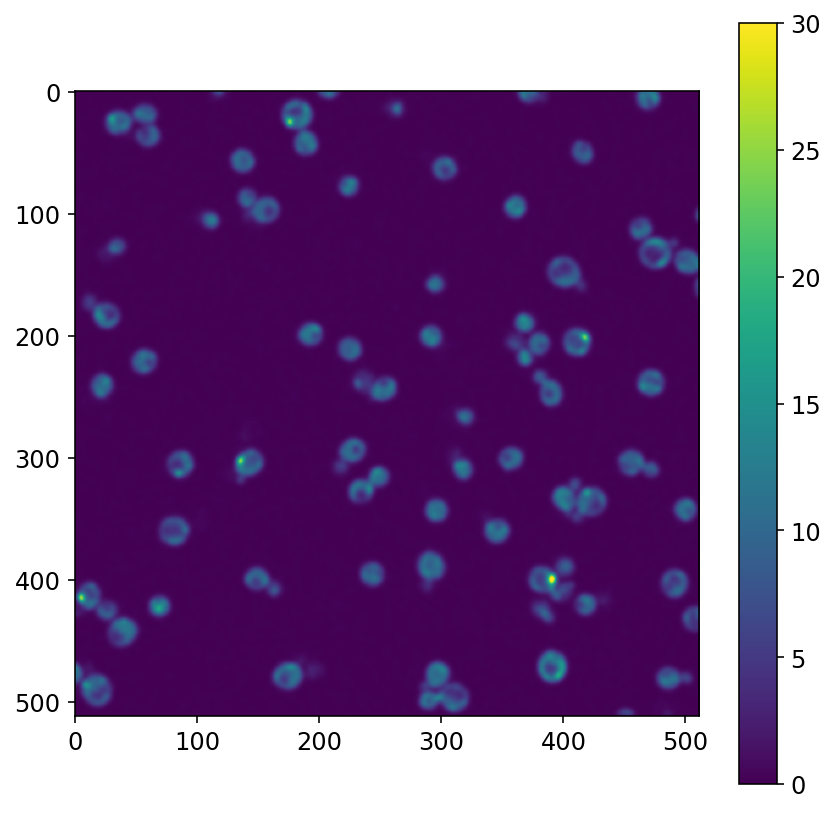

In [7]:
blurimg = gaussian(int_img, preserve_range=True, sigma=2)

fig, ax = plt.subplots(figsize=(7,7))
plt.imshow(blurimg, vmin=0, vmax=30)
plt.colorbar()

# binarize image

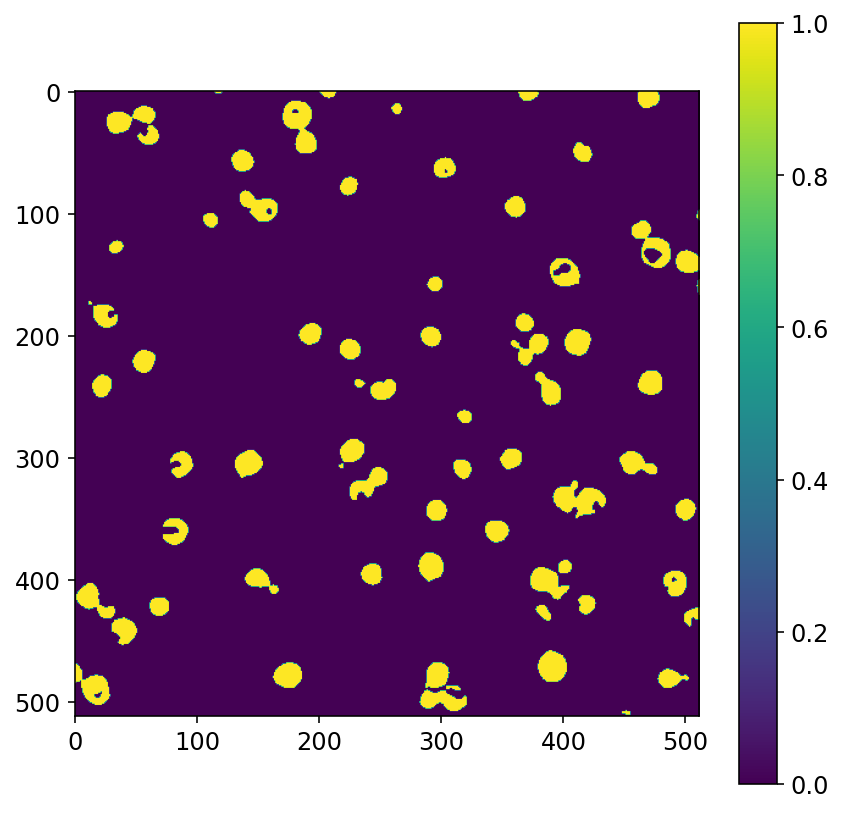

In [8]:
bin_img = blurimg > 5

fig, ax = plt.subplots(figsize=(7,7))
plt.imshow(bin_img)
plt.colorbar()

# fit decays from segmented pixels only

In [10]:
flimg  = pc.load_sdt("sample_data/SDT_c01.sdt", use_dask=False).isel(file_info=0).sel(channel="M2")
dc = pc.decay_curve(flimg, mask=bin_img)

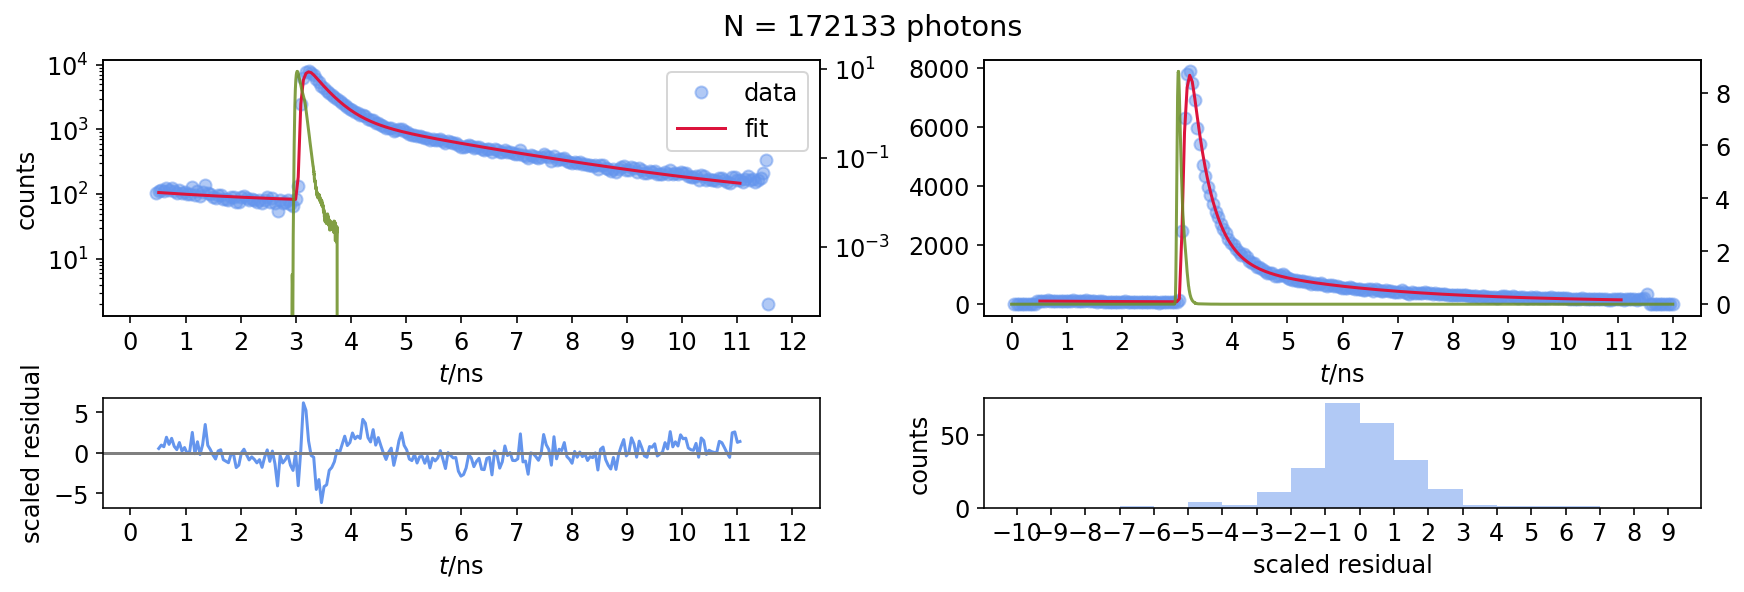

,value,err,min,max,step
shift,17.499992,0.349725,-300.000,300.0,1.000
A,0.993802,0.001058,0.700,1.0,0.001
tau1,2.633815,0.143109,1.000,9.0,0.001
tau2,0.337070,0.006761,0.010,1.0,0.001
f,0.145008,0.005638,0.001,1.0,0.001


In [11]:
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)

parameters = {
    "shift": {"value": 0    , "err": np.nan, "min": -300 , "max":   300, "step": 1   },
    "A":     {"value": 0.995, "err": np.nan, "min": 0.700, "max": 1.000, "step": 1e-3},
    "tau1":  {"value": 1.8,   "err": np.nan, "min": 1.000, "max": 9.000, "step": 1e-3},
    "tau2":  {"value": 0.25,  "err": np.nan, "min": 0.010, "max": 1.000, "step": 1e-3},
    "f":     {"value": 0.25,  "err": np.nan, "min": 0.001, "max": 1.000, "step": 1e-3},
}

fit_result, fit_status = dg.fit(model="2exp", parameters=parameters, plot=True)
display(fit_result)